In [1]:
import cv2     # for capturing videos
import os 
import shutil
import math   # for mathematical operations
import pandas as pd
import pickle
import numpy as np   
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from glob import glob
from tqdm import tqdm
import tensorflow as tf 
from tensorflow.keras.preprocessing import image   # for preprocessing the images
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render, init_notebook_plotting
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16379497450660707184
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7347613216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6892062830417803198
physical_device_desc: "device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:0a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7596800736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11252568984326227376
physical_device_desc: "device: 1, name: GeForce RTX 2080 SUPER, pci bus id: 0000:0b:00.0, compute capability: 7.5"
]


In [3]:
with tf.device('/device:GPU:0'):
    if tf.test.gpu_device_name():
        print("GPU")
    else:
        print("no GPU")

GPU


# Model

In [4]:
def build_model(num_hidden_layers, alpha, dropout_rate, input_samples):
    with tf.device('/device:GPU:0'):
        if tf.test.gpu_device_name():
            units = int(input_samples / (alpha * 21))
            model = tf.keras.Sequential()
            for i in range(num_hidden_layers):
                if(i == 0):
                    model.add(LSTM(units = units, return_sequences=True, input_shape=(20, 2048)))
                    model.add(Dropout(dropout_rate))
                elif(i>0 and i<num_hidden_layers-1):
                    model.add(LSTM(units = int(2/3 * units), return_sequences=True))
                    model.add(Dropout(dropout_rate))
                else:
                    model.add(LSTM(units = int(2/3 * 2/3 * units)))
                    model.add(Dropout(dropout_rate))
            model.add(Dense(units=1, activation='sigmoid'))
            return model
        else:
            print("GPU is not available")

In [8]:
def training(parameterization, option, X_train, y_train, X_test, y_test):
    with tf.device('/device:GPU:0'):
        if tf.test.gpu_device_name():
            
            config = tf.compat.v1.ConfigProto()
            config.gpu_options.allow_growth = True
            session = tf.compat.v1.Session(config=config)
            
            if (option=="tuning"):
                model = build_model(parameterization.get('num_hidden_layers'),
                                    parameterization.get('alpha'),
                                    parameterization.get('dropout_rate'),
                                   X_train.shape[0])
            else:
                model = build_model(parameterization.get('num_hidden_layers'),
                                    parameterization.get('alpha'),
                                    parameterization.get('dropout_rate'),
                                   X_train.shape[0])
            
            opt = parameterization.get('optimizer')
            opt = opt.lower()
            
            NUM_EPOCHS = parameterization.get('num_epochs')
            
            learning_rate = parameterization.get('learning_rate')
                    
            if opt == 'adam':
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            elif opt == 'rms':
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            else:
                if(learning_rate >= 0.1):
                    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate=learning_rate,
                        decay_steps=10000,
                        decay_rate=0.96,
                        staircase=True)
                    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
                else:
                    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate=learning_rate,
                        decay_steps=10000,
                        decay_rate=0.96,
                        staircase=True)
                    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
                    
            model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=[tf.keras.metrics.binary_accuracy])

            if (option == "tuning"):
                res = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=parameterization.get('batch_size'), validation_data=(X_test, y_test))
            else:
                es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
                mcp_save = ModelCheckpoint('weight_1607.hdf5', save_best_only=True, monitor='val_loss', mode='min')
                res = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=parameterization.get('batch_size'), validation_data=(X_test, y_test), callbacks=[es, mcp_save])

            valloss = np.array(res.history['val_loss'][:])
            vallossmean = valloss.mean()
            sem = valloss.std()
            
            if np.isnan(vallossmean):
                return 9999.0, 0.0
            
            if (option == "tuning"):
                return vallossmean, sem
            else:
                return res, mcp_save, model
        else:
            print("GPU is not available")

In [7]:
global X_train, y_train, X_test, y_test
X_train = pickle.load(open("X_train.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))
X_test = pickle.load(open("X_test.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))
best_parameters = pickle.load(open("best_parameters.pickle", "rb"))

In [9]:
#1607
best_parameters['learning_rate'] = best_parameters['learning_rate']/10000
best_parameters['num_epochs'] = 500
best_parameters

{'learning_rate': 1.6699229355063293e-05,
 'dropout_rate': 0.27924185357987885,
 'alpha': 10,
 'num_hidden_layers': 3,
 'num_epochs': 500,
 'batch_size': 64,
 'optimizer': 'sgd'}

In [10]:
#1607
history, mcp_save, best_model = training(best_parameters, "best", X_train, y_train, X_test, y_test)

Epoch 1/500
1835/1835 [==============================] - 38s 19ms/step - loss: 0.6991 - binary_accuracy: 0.4854 - val_loss: 0.6944 - val_binary_accuracy: 0.4865
Epoch 2/500
1835/1835 [==============================] - 32s 18ms/step - loss: 0.6961 - binary_accuracy: 0.4987 - val_loss: 0.6918 - val_binary_accuracy: 0.5073
Epoch 3/500
1835/1835 [==============================] - 32s 18ms/step - loss: 0.6935 - binary_accuracy: 0.5146 - val_loss: 0.6895 - val_binary_accuracy: 0.5298
Epoch 4/500
1835/1835 [==============================] - 32s 18ms/step - loss: 0.6911 - binary_accuracy: 0.5252 - val_loss: 0.6874 - val_binary_accuracy: 0.5421
Epoch 5/500
1835/1835 [==============================] - 32s 18ms/step - loss: 0.6896 - binary_accuracy: 0.5315 - val_loss: 0.6853 - val_binary_accuracy: 0.5555
Epoch 6/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.6870 - binary_accuracy: 0.5419 - val_loss: 0.6834 - val_binary_accuracy: 0.5662
Epoch 7/500
1835/1835 [===========

1835/1835 [==============================] - 33s 18ms/step - loss: 0.5821 - binary_accuracy: 0.7115 - val_loss: 0.5746 - val_binary_accuracy: 0.7225
Epoch 102/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.5816 - binary_accuracy: 0.7103 - val_loss: 0.5736 - val_binary_accuracy: 0.7226
Epoch 103/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.5794 - binary_accuracy: 0.7138 - val_loss: 0.5727 - val_binary_accuracy: 0.7236
Epoch 104/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.5792 - binary_accuracy: 0.7121 - val_loss: 0.5717 - val_binary_accuracy: 0.7251
Epoch 105/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.5770 - binary_accuracy: 0.7145 - val_loss: 0.5708 - val_binary_accuracy: 0.7257
Epoch 106/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.5767 - binary_accuracy: 0.7161 - val_loss: 0.5698 - val_binary_accuracy: 0.7263
Epoch 107/500
1835/1835 [===========

1835/1835 [==============================] - 33s 18ms/step - loss: 0.5033 - binary_accuracy: 0.7715 - val_loss: 0.4940 - val_binary_accuracy: 0.7801
Epoch 202/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.5019 - binary_accuracy: 0.7714 - val_loss: 0.4933 - val_binary_accuracy: 0.7807
Epoch 203/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4994 - binary_accuracy: 0.7739 - val_loss: 0.4927 - val_binary_accuracy: 0.7812
Epoch 204/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4991 - binary_accuracy: 0.7732 - val_loss: 0.4921 - val_binary_accuracy: 0.7815
Epoch 205/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4972 - binary_accuracy: 0.7760 - val_loss: 0.4914 - val_binary_accuracy: 0.7820
Epoch 206/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4998 - binary_accuracy: 0.7726 - val_loss: 0.4908 - val_binary_accuracy: 0.7821
Epoch 207/500
1835/1835 [===========

1835/1835 [==============================] - 33s 18ms/step - loss: 0.4511 - binary_accuracy: 0.8045 - val_loss: 0.4434 - val_binary_accuracy: 0.8083
Epoch 302/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4537 - binary_accuracy: 0.8020 - val_loss: 0.4431 - val_binary_accuracy: 0.8078
Epoch 303/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4505 - binary_accuracy: 0.8043 - val_loss: 0.4427 - val_binary_accuracy: 0.8085
Epoch 304/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4515 - binary_accuracy: 0.8027 - val_loss: 0.4423 - val_binary_accuracy: 0.8085
Epoch 305/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4487 - binary_accuracy: 0.8058 - val_loss: 0.4420 - val_binary_accuracy: 0.8087
Epoch 306/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4503 - binary_accuracy: 0.8044 - val_loss: 0.4416 - val_binary_accuracy: 0.8088
Epoch 307/500
1835/1835 [===========

1835/1835 [==============================] - 33s 18ms/step - loss: 0.4266 - binary_accuracy: 0.8190 - val_loss: 0.4167 - val_binary_accuracy: 0.8231
Epoch 402/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4249 - binary_accuracy: 0.8199 - val_loss: 0.4165 - val_binary_accuracy: 0.8229
Epoch 403/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4273 - binary_accuracy: 0.8172 - val_loss: 0.4163 - val_binary_accuracy: 0.8230
Epoch 404/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4253 - binary_accuracy: 0.8194 - val_loss: 0.4161 - val_binary_accuracy: 0.8233
Epoch 405/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4252 - binary_accuracy: 0.8197 - val_loss: 0.4160 - val_binary_accuracy: 0.8234
Epoch 406/500
1835/1835 [==============================] - 33s 18ms/step - loss: 0.4245 - binary_accuracy: 0.8200 - val_loss: 0.4158 - val_binary_accuracy: 0.8236
Epoch 407/500
1835/1835 [===========

In [18]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 559)           5831488   
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 559)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 372)           1386816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 372)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 248)               616032    
_________________________________________________________________
dropout_5 (Dropout)          (None, 248)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

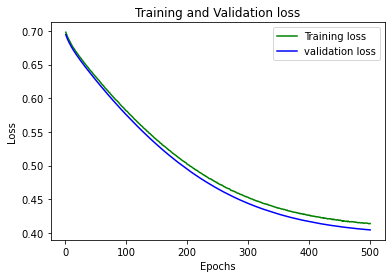

In [12]:
#1607
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, 501)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

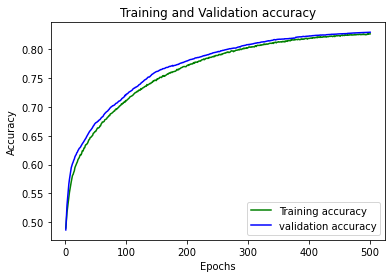

In [14]:
#1607
acc_train = history.history['binary_accuracy']
acc_val = history.history['val_binary_accuracy']
epochs = range(1, 501)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Saving

In [11]:
best_model.save("model_1607")

INFO:tensorflow:Assets written to: model_1607/assets


INFO:tensorflow:Assets written to: model_1607/assets
